In [6]:
import numpy as np
import pandas as pd
from scipy import stats

import xarray as xr
import os
import matplotlib.pyplot as plt

import sys
from bslibs.plot.qqplot import qqplot
from glob import glob
import seaborn as sns
from datetime import datetime

In [78]:
#Setup vars
ensembles = ["batch_870_ant","batch_871_ant","batch_872_ant","batch_794_nat","batch_793_ant"] 
in_file_path = "/mnt/temp/projects/otago_uni_marsden/data_keep/weather_at_home/dunedin"


In [79]:
# Grabbing all Data
df = pd.DataFrame()
time_df = pd.DataFrame()
maxima_df = pd.DataFrame()
for ens in ensembles: 
    file_path_list = list(glob(os.path.join(in_file_path,ens,"*.nc")))
    ens_vals = np.array([])
    time_vals = np.array([])
    maxima_vals = np.array([])
    for fl in file_path_list:
        with xr.open_dataset(fl) as ds: 
            if len(ds.precipitation[:,0].values)==600:
                ens_vals = np.append(ens_vals,ds.precipitation[-360::,0].values*86400,axis = 0)
                time_vals = np.append(time_vals,ds.time1[-360::].values,axis=0)
                maxima_vals = np.append(maxima_vals,np.max(ds.precipitation[-360::,0].values*86400))

    df_2 = pd.DataFrame({ens: ens_vals})
    time_df_2 = pd.DataFrame({ens: time_vals})
    maxima_df_2 = pd.DataFrame({ens: maxima_vals})
    df = pd.concat([df,df_2],axis = 1)
    time_df = pd.concat([time_df,time_df_2],axis=1)
    maxima_df = pd.concat([maxima_df,maxima_df_2],axis=1)

weather_station = pd.read_csv("/mnt/temp/projects/emergence/data_keep/station_data/dunedin_btl_gardens_precip.tsv",sep='\t', parse_dates=['Date(UTC)'], skiprows=8)

weather_station['year'] = pd.DatetimeIndex(pd.to_datetime(weather_station['Date(UTC)'].values, format='%Y%m%d:%H%M')).year

maxima_vals = []
for yr in np.unique(weather_station['year'].values):
    mask = weather_station['year'].values == yr
    maxima_vals.append(np.max(weather_station['Amount(mm)'].values[mask]))

maxima_df_2 = pd.DataFrame({"weather_station": maxima_vals})
maxima_df = pd.concat([maxima_df,maxima_df_2],axis=1)
df = pd.concat([df,weather_station["Amount(mm)"]],axis=1)
df = df.rename(columns={"Amount(mm)": "weather_station"})

ensembles.append("weather_station")



In [80]:
df
ensembles

['batch_870_ant',
 'batch_871_ant',
 'batch_872_ant',
 'batch_794_nat',
 'batch_793_ant',
 'weather_station']

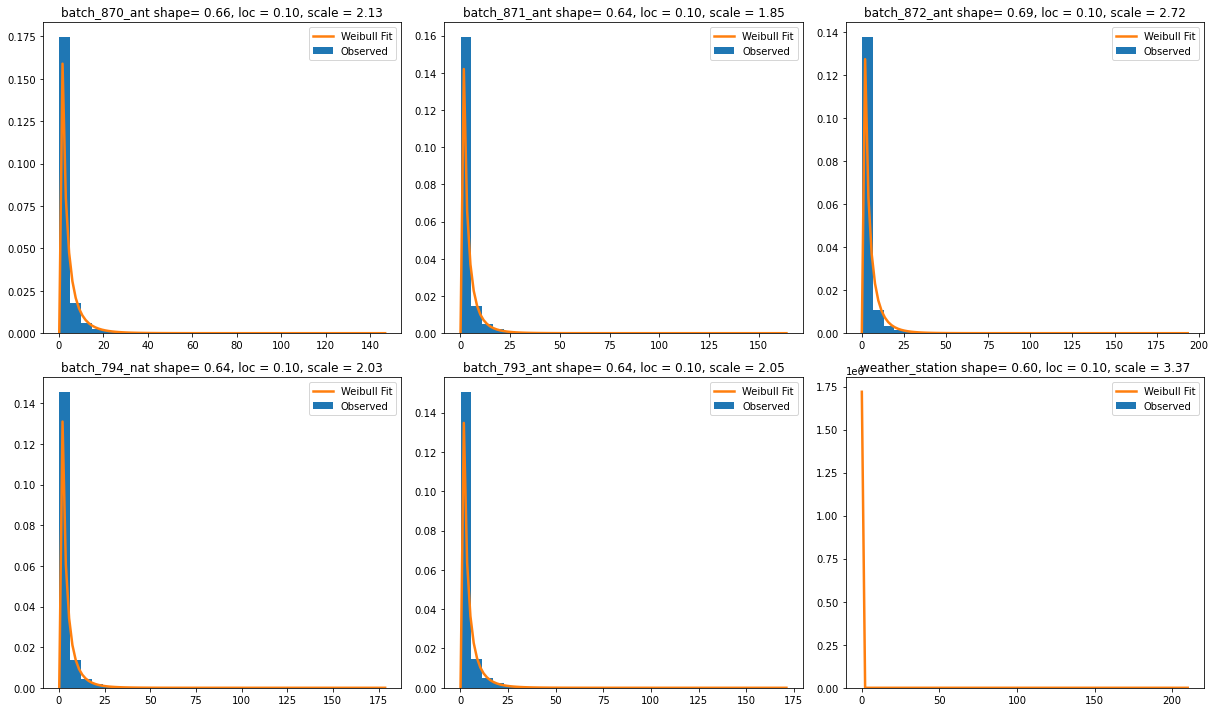

In [86]:
# Weibull fits
subplot_dim = (2,3)
fig,axes = plt.subplots(*subplot_dim,figsize =(17,10))
i=0
censor=0.1
for col in axes: 
    for ax in col:
        if i < len(ensembles):
            rf_dat = df[ensembles[i]].values[df[ensembles[i]].values>=censor]
            x = np.linspace(censor,max(rf_dat),100)
            fit = stats.weibull_min.fit(rf_dat)
            weib_probs = stats.weibull_min.pdf(x,*fit)
            ax.hist(rf_dat,density =True, label = "Observed", bins=30)
            ax.plot(x,weib_probs, lw = 2.5, label = "Weibull Fit") 
            ax.set_title(f"{ensembles[i]} shape= {fit[0]:0.2f}, loc = {fit[1]:0.2f}, scale = {fit[2]:0.2f}")
            ax.legend()
            i+=1

plt.tight_layout()

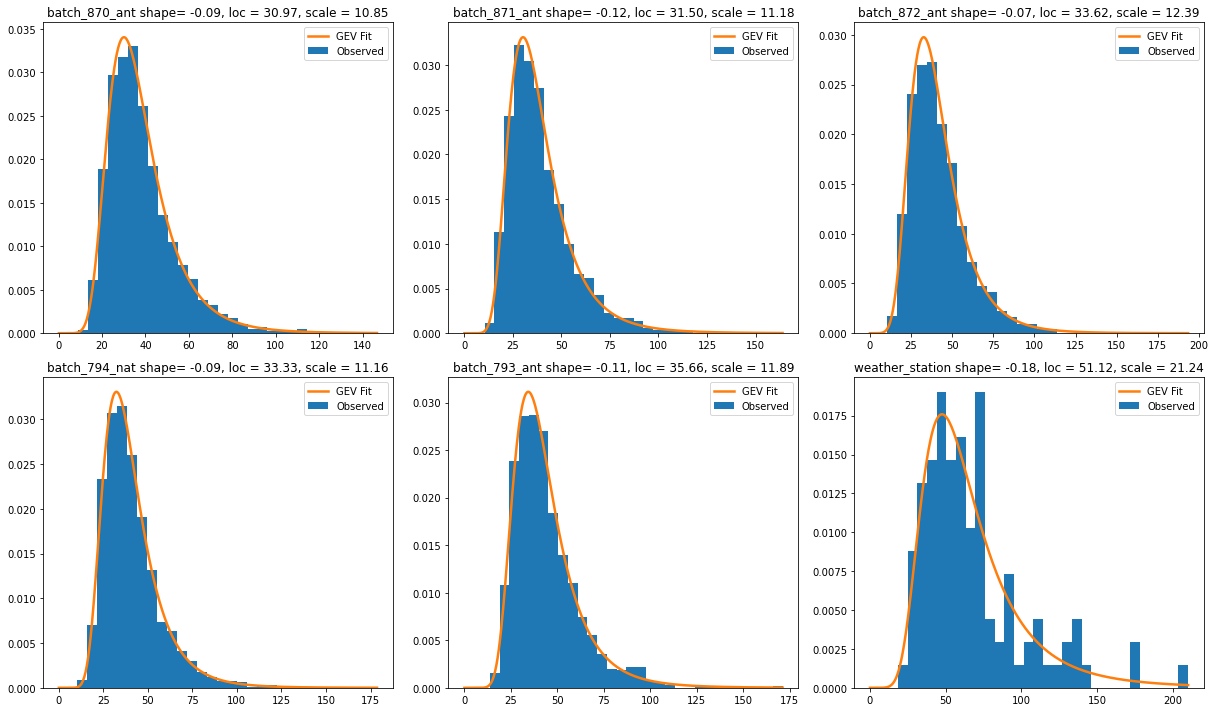

In [87]:
#GEV fits
subplot_dim = (2,3)
fig,axes = plt.subplots(*subplot_dim,figsize =(17,10))
i=0
censor=0.1
for col in axes: 
    for ax in col:
        if i < len(ensembles):
            maxima_dat = maxima_df[ensembles[i]].values[maxima_df[ensembles[i]].values>=censor]
            x = np.linspace(censor,max(maxima_dat),500)
            fit = stats.genextreme.fit(maxima_dat)
            gev_probs = stats.genextreme.pdf(x,*fit)
            ax.hist(maxima_dat,density =True, label = "Observed", bins=30)
            ax.plot(x,gev_probs, lw = 2.5, label = "GEV Fit") 
            ax.set_title(f"{ensembles[i]} shape= {fit[0]:0.2f}, loc = {fit[1]:0.2f}, scale = {fit[2]:0.2f}")
            ax.legend()
            i+=1

plt.tight_layout()


Text(0, 0.5, 'Rainfall(mm)')

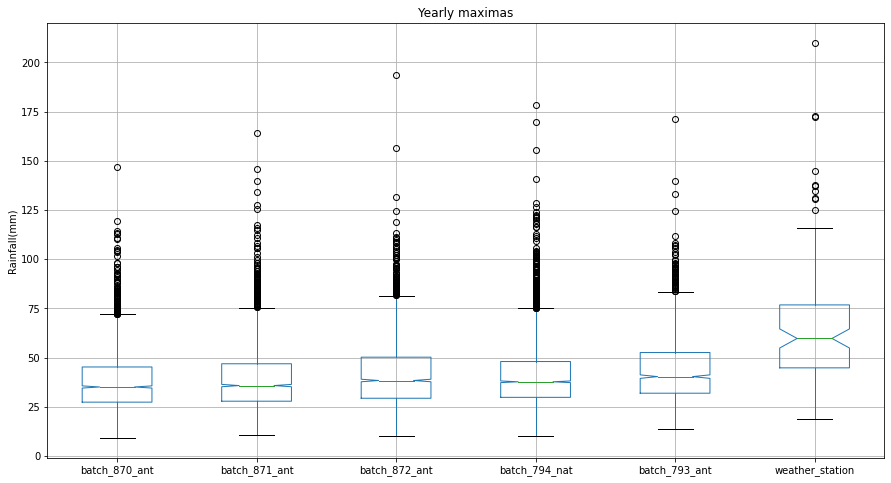

In [89]:
# maxima box-plots 
fig,ax = plt.subplots(figsize=(15,8))
maxima_df.boxplot(ax = ax,**{"notch": True,"vert": True})
ax.set_title("Yearly maximas")
ax.set_ylabel("Rainfall(mm)")
